In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake

## Short version: Get monthly-mean surface 2D data for tco2559-ng5-cycle3 and make a plot

In [2]:
datapath='/work/bm1235/a270046/cycle3/multio_cycle3/gribscan_monthly_native/'
datazarr=datapath+'/json.dir/atm2d.json' # all monthly 2D surface fields, this is the whole dataset
datatmp = xr.open_zarr("reference::"+datazarr, consolidated=False)
data = datatmp.isel(time=slice(None, None, 2))

In [3]:
#cat = intake.open_catalog("../catalog.yaml")
#run = cat.IFS["tco3999-ng5"]
#data = run.ICMGG_atm2d.to_dask()

#### list all 2D variables; click arrow next to 'Data variables" to see the list; click the icons at the end of each row for more info, such as long name and shape

In [4]:
data

<xarray.Dataset>
Dimensions:  (time: 36, value: 26306560)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-15 2020-02-15 ... 2022-12-15
Dimensions without coordinates: value
Data variables: (12/59)
    100u     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2t       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ...       ...
    tisr     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    tp       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    tsr      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ttr      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    zos      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

#### Get the model IFS grid (points_ifs)

In [6]:
model_lon = data.lon.values
model_lat = data.lat.values
nonan = ~((np.isnan(model_lon)) | (np.isnan(model_lat)))
lat_nonan = model_lat[nonan]
lon_nonan = model_lon[nonan]
lon_nonan = np.where(lon_nonan>180, lon_nonan-360, lon_nonan)
points_ifs = np.vstack((lon_nonan, lat_nonan)).T

#### Interpolate an example variable to a small target grid; here: zoom of Europe (lon2, lat2)

In [8]:
lon = np.linspace(-30, 60, 90*10)
lat = np.linspace(33, 72, (72-33)*10)
lon2, lat2 = np.meshgrid(lon, lat)

#### Pick the example variable and do the actual interpolation

In [9]:
data_sample = data['2t'][0, :]

nn_interpolation = NearestNDInterpolator(points_ifs, data_sample.values[nonan])
interpolated_nn = nn_interpolation((lon2, lat2))

#### Plot it

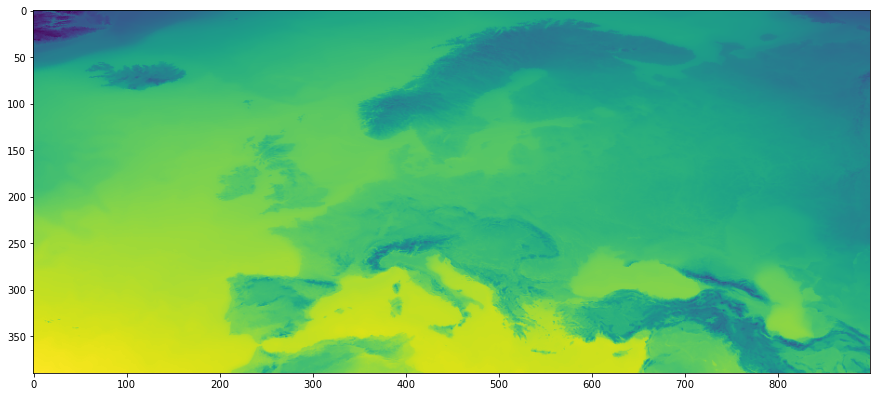

In [10]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn))

## Longer version

In [11]:
data['2t'] # pick any variable here

<xarray.DataArray '2t' (time: 36, value: 26306560)>
dask.array<getitem, shape=(36, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-15 2020-02-15 ... 2022-12-15
Dimensions without coordinates: value
Attributes:
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   avg
    gridType:                   reduced_gg
    shortName:                  2t
    units:                      K
    name:                       2 metre temperature
    cfVarName:                  t2m
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

look at the variables by taking the first time step, but all spatial points

In [12]:
data_sample = data['2t'][0,:]
data_sample

<xarray.DataArray '2t' (value: 26306560)>
dask.array<getitem, shape=(26306560,), dtype=float64, chunksize=(26306560,), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    time     datetime64[ns] 2020-01-15
Dimensions without coordinates: value
Attributes:
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   avg
    gridType:                   reduced_gg
    shortName:                  2t
    units:                      K
    name:                       2 metre temperature
    cfVarName:                  t2m
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

In [13]:
data_sample.shape # the number of points

(26306560,)

In [14]:
data_sample.values # access the actual values, this can take a short moment

array([243.45742798, 243.44104004, 243.42700195, ..., 242.41648865,
       242.42791748, 242.43363953])

In [15]:
nn_interpolation = NearestNDInterpolator(points_ifs, data_sample.values[nonan]) # create an interpolator, this takes a moment 

In [16]:
interpolated_nn = nn_interpolation((lon2, lat2)) # this step is quite fast and performs the actual interpolation to the target grid

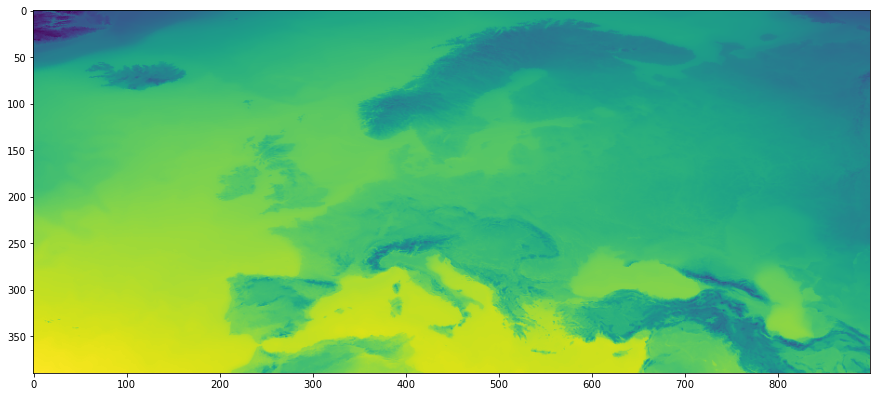

In [17]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn))

## Find a point on the map and plot timeseries

In [18]:
def tunnel_fast1d(latvar, lonvar, lonlat):
    """
    Find closest point in a set of (lat,lon) points to specified pointd.
    Parameters:
    -----------
        latvar : ndarray
            1d array with lats
        lonvar : ndarray
            1d array with lons
        lonlat : ndarray
            2d array with the shape of [2, number_of_point],
            that contain coordinates of the points
    Returns:
    --------
        node : int
            node number of the closest point
    Taken from here http://www.unidata.ucar.edu/blogs/developer/en/entry/accessing_netcdf_data_by_coordinates
    and modifyed for 1d
    """

    rad_factor = np.pi / 180.0  # for trignometry, need angles in radians
    # Read latitude and longitude from file into numpy arrays
    latvals = latvar[:] * rad_factor
    lonvals = lonvar[:] * rad_factor

    # Compute numpy arrays for all values, no loops
    clat, clon = np.cos(latvals), np.cos(lonvals)
    slat, slon = np.sin(latvals), np.sin(lonvals)

    clat_clon = clat * clon
    clat_slon = clat * slon

    lat0_rad = lonlat[1, :] * rad_factor
    lon0_rad = lonlat[0, :] * rad_factor

    delX_pre = np.cos(lat0_rad) * np.cos(lon0_rad)
    delY_pre = np.cos(lat0_rad) * np.sin(lon0_rad)
    delZ_pre = np.sin(lat0_rad)

    nodes = np.zeros((lonlat.shape[1]))
    for i in range(lonlat.shape[1]):
        delX = delX_pre[i] - clat_clon
        delY = delY_pre[i] - clat_slon
        delZ = delZ_pre[i] - slat
        dist_sq = delX ** 2 + delY ** 2 + delZ ** 2
        minindex_1d = dist_sq.argmin()  # 1D index of minimum element
        node = np.unravel_index(minindex_1d, latvals.shape)
        nodes[i] = node[0]

    return nodes.astype('int')

In [19]:
# the point we are interesting in
lon_target = -10
lat_target = 50

In [20]:
points = np.array([[lat_target],[lon_target]])

In [21]:
index = tunnel_fast1d(model_lon, model_lat, points)

In [22]:
# in the model, this is the point
model_lon[index[0]], model_lat[index[0]]

(349.9912434325744, 50.004882010120575)

In [23]:
data['2t'] # first dimension is time, second dimension is spatial dimension

<xarray.DataArray '2t' (time: 36, value: 26306560)>
dask.array<getitem, shape=(36, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-15 2020-02-15 ... 2022-12-15
Dimensions without coordinates: value
Attributes:
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   avg
    gridType:                   reduced_gg
    shortName:                  2t
    units:                      K
    name:                       2 metre temperature
    cfVarName:                  t2m
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

In [24]:
data['2t'][:, index[0]] # this would read all time steps for this point 

<xarray.DataArray '2t' (time: 36)>
dask.array<getitem, shape=(36,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 dask.array<chunksize=(), meta=np.ndarray>
    lon      float64 dask.array<chunksize=(), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-15 2020-02-15 ... 2022-12-15
Attributes:
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   avg
    gridType:                   reduced_gg
    shortName:                  2t
    units:                      K
    name:                       2 metre temperature
    cfVarName:                  t2m
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

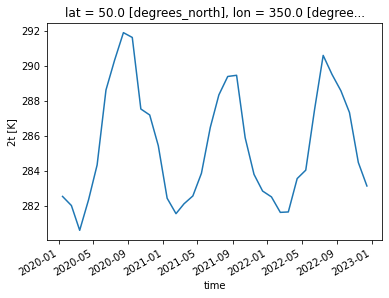

In [25]:
data['2t'][:, index[0]].plot() # plot all years

In [26]:
series=data['2t'].sel(time=slice('2020-01-15','2020-04-15'))[:,index[0]].values # select 4 months only, by date
series

array([282.54888916, 282.02819824, 280.61199951, 282.35443115])

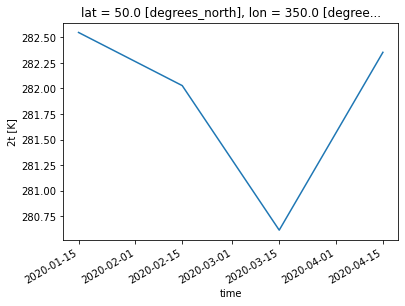

In [27]:
data['2t'].sel(time=slice('2020-01-15','2020-04-15'))[:,index[0]].plot()